In [2]:
import os
from os import listdir

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from PIL import Image
import rasterio
from rasterio.plot import show
import requests
import shapely
from shapely import segmentize
from shapely.ops import substring
from shapely.geometry import LineString, Point
from shapely.geometry.polygon import Polygon


In [3]:
## Viewing cross-section example

# # Inputs
# lid = 'bltn7'
# huc = '06010105'
# catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
# catfim_outputs_path = '/data/catfim/emily_test/hand_4_5_11_1_catfim_datavis_flow_based/'

# Viewing PACI1

# Inputs
lid = 'paci1'
huc = '17060108'
catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
catfim_outputs_path = '/data/catfim/hand_4_5_11_1_stage_based/'


In [191]:
# ## Viewing Alaska BEFORE updates

# # Inputs
# lid = 'apta2'
# huc = '19020301'
# catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
# catfim_outputs_path = '/data/catfim/hand_4_5_11_1_flow_based'

## Viewing Alaska updates

# # Inputs
# lid = 'apta2'
# huc = '19020301'
# catfim_inputs_path = '/data/previous_fim/fim_4_5_2_11'
# catfim_outputs_path = '/data/catfim/emily_test/AK_new_wrds_flow_based/'





### Reading in and processing CatFIM library and geospatial data

In [5]:
## Read in data, constructing filepaths as needed

# Read in HAND output flowlines
flowline_path = os.path.join(catfim_inputs_path, huc,'nwm_subset_streams_levelPaths_dissolved.gpkg')
flowline_gdf = gpd.read_file(flowline_path)

# Read in CatFIM outputs
catfim_outputs_mapping_path = os.path.join(catfim_outputs_path, 'mapping')

for file in os.listdir(catfim_outputs_mapping_path):
    if file.endswith('catfim_library.gpkg'):
        catfim_library_path = os.path.join(catfim_outputs_path, 'mapping', file)
    elif file.endswith('catfim_sites.gpkg'):
        catfim_points_path = os.path.join(catfim_outputs_mapping_path, file)

try:
    catfim_library = gpd.read_file(catfim_library_path)
    catfim_points = gpd.read_file(catfim_points_path)

except IOError:
    print(f'Error opening CatFIM outputs from {catfim_outputs_path}:')
    print(IOError)
    sys.exit()
    
print('HAND-FIM and CatFIM outputs have been read in.')

HAND-FIM and CatFIM outputs have been read in.


In [6]:
## Get point and flowline for LID 

# Filter points to LID
points_filt_gdf = catfim_points[catfim_points['ahps_lid'] == lid] 

if len(points_filt_gdf) > 1:
    print(f'ERROR: Multiple points found for lid {lid}.')
    sys.exit()

# Put the point into the projection of the flowlines
points_filt_gdf = points_filt_gdf.to_crs(flowline_gdf.crs) 

# Find the flowline nearest to the point 
flowline_filt_gdf = gpd.sjoin_nearest(flowline_gdf, points_filt_gdf, max_distance=100)

print(f'Filtered points and flowlines for {lid}')

Filtered points and flowlines for paci1


In [8]:
## Subset CatFIM results and apply the appropriate symbology

catfim_library_filt = catfim_library[catfim_library['ahps_lid']==lid]
catfim_library_filt = catfim_library_filt.to_crs(points_filt_gdf.crs) # TODO: check that this is doing what we want it to

# Create dictionary of color and orders
categories = ['action', 'minor', 'moderate', 'major', 'record']
colors = ['yellow', 'orange', 'red', 'purple', 'cyan']
orders = [5, 4, 3, 2, 1]

colordict = dict(zip(categories, colors))  
orderdict = dict(zip(categories, orders))  

catfim_library_filt['color'] = catfim_library_filt['magnitude'].apply(lambda x: colordict[x])
catfim_library_filt['plot_order'] = catfim_library_filt['magnitude'].apply(lambda x: orderdict[x])

catfim_library_filt = catfim_library_filt.sort_values(by='plot_order') 

print('Subsetted, filtered, and applied visualization preferences to CatFIM library.')
# print(catfim_library_filt)

Subsetted, filtered, and applied visualization preferences to CatFIM library.


### Creating Perpendicular Cross-section

In [9]:
## Create cross-section of flowline

# Input cross section length
xsection_length = 1000 # meters or feet


# ------------------------------------------------------------------


# Extract the line and the point
line = flowline_filt_gdf.geometry.iloc[0]
point = points_filt_gdf.geometry.iloc[0]


# Find the segment of the line near the point of interest
segment_length = 20 # meters or feet 
segment_start_distance = max(0, line.project(point) - segment_length / 2)
segment_end_distance = min(line.length, segment_start_distance + segment_length)

# Create a shorter segment from the original line
short_segment = LineString([
    line.interpolate(segment_start_distance),
    line.interpolate(segment_end_distance)
])

# Calculate the slope of the shorter line segment
line_vector = np.array(short_segment.xy[1]) - np.array(short_segment.xy[0])
line_vector /= np.linalg.norm(line_vector)  # Normalize
perpendicular_vector = np.array([-line_vector[1], line_vector[0]])  # Perpendicular vector

# Create the cross section line (10 meters long)
half_length = xsection_length / 2
start_point = (point.x + half_length * perpendicular_vector[0], point.y + half_length * perpendicular_vector[1])
end_point = (point.x - half_length * perpendicular_vector[0], point.y - half_length * perpendicular_vector[1])
new_line = LineString([start_point, end_point])

# Create a GeoDataFrame for the new line
xsection_gdf = gpd.GeoDataFrame({'geometry': [new_line]}, crs=flowline_filt_gdf.crs)

# xsection_gdf = gdf.set_crs(flowline_filt_gdf.crs)


print(f'Created cross-section of length {xsection_length}')

IndexError: single positional indexer is out-of-bounds

In [11]:
## Convert everything to the plotting projection

# Set EPSG for plotting data... 5070 seems to work well
EPSG = 5070


points_filt_gdf = points_filt_gdf.to_crs(EPSG)

flowline_filt_gdf = flowline_filt_gdf.to_crs(EPSG)

catfim_library_filt = catfim_library_filt.to_crs(EPSG)

xsection_gdf = xsection_gdf.to_crs(EPSG)



### Plotting

In [12]:
## Plot the cross section

plot_title = ''


# ------------------------------------------------------------------


# Plot gdf2 first to set the extent
ax = xsection_gdf.plot(figsize=(6, 6), color='lightgray')

# Plot gdf1 and gdf3 on top of gdf2
points_filt_gdf.plot(ax=ax, color='blue', alpha=0.5)  # Adjust color and alpha as needed
flowline_filt_gdf.plot(ax=ax, color='green', alpha=0.5)  # Adjust color and alpha as needed

# catfim_library.plot(ax=ax)

# Set the plot extent to the bounds of the line segment
minx, miny, maxx, maxy = xsection_gdf.total_bounds
modifier = 100 # how much to widen the extent by
ax.set_xlim(minx-modifier, maxx+modifier)
ax.set_ylim(miny-modifier, maxy+modifier)
ax.set_title(plot_title)


plt.show()

NameError: name 'xsection_gdf' is not defined

/tmp/ipykernel_9767/2951902212.py:13: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  flowline_filt_gdf.plot(ax=ax, color='blue', alpha=0.8)


Text(0.5, 1.0, '')

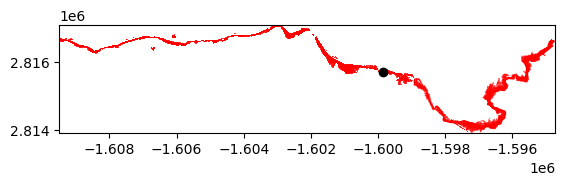

In [13]:
## Plot the subsetted CatFIM library, with the CatFIM library as the extent

plot_title = ''


# ------------------------------------------------------------------

# Set up CatFIM plot
f, ax = plt.subplots()
catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.75)

# Additional geodataframe layers
flowline_filt_gdf.plot(ax=ax, color='blue', alpha=0.8)  
points_filt_gdf.plot(ax=ax, color='black', alpha=1)  

# Set the plot extent to the bounds of the CatFIM section
minx, miny, maxx, maxy = catfim_library_filt.total_bounds
modifier = 10 # how much to widen the extent by
ax.set_xlim(minx-modifier, maxx+modifier)
ax.set_ylim(miny-modifier, maxy+modifier)

ax.set_title(plot_title)

In [214]:
# # Add additional geodataframe layers
# catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.5)
# flowline_filt_gdf.plot(ax=ax, color='green', alpha=0.5) 
# # xsection_gdf.plot(ax=ax, color='white', alpha=0.5)
# xsection_points_gdf.plot(ax=ax, color='green', alpha=0.8)
# points_filt_gdf.plot(ax=ax, color='blue', alpha=0.5)


# temp = catfim_library_filt.to_crs(EPSG)
# temp.crs


/tmp/ipykernel_9767/513669359.py:44: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  flowline_filt_gdf.plot(ax=ax, color='green', alpha=0.5)


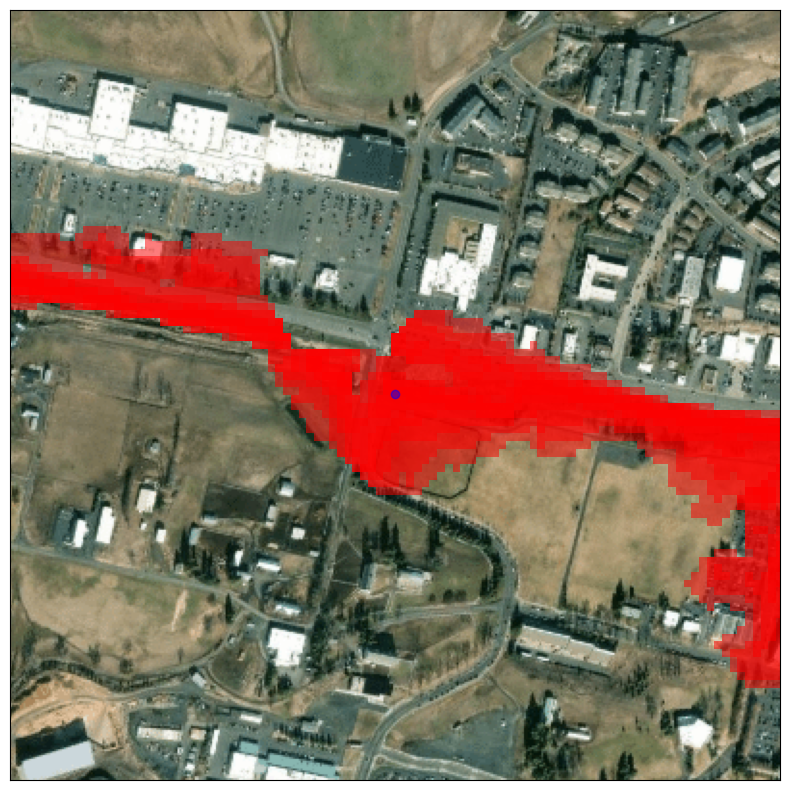

In [15]:
## Plot data layers on top of a ESRI basemap... bounding box determined by a centroid

# Input plot parameters
plot_title = ''

# Input information to calculate bounding box
map_length = 1000
map_centroid = points_filt_gdf


# ------------------------------------------------------------------


# Reproject centroid
map_centroid = map_centroid.to_crs(EPSG)

# Calculate bounding box
ycoord = int(map_centroid.get_coordinates()['y'].iloc[0])
xcoord = int(map_centroid.get_coordinates()['x'].iloc[0])

map_length_half = map_length/2

xleft = xcoord-map_length_half
xright = xcoord+map_length_half
ybottom = ycoord-map_length_half
ytop = ycoord+map_length_half

x = (xleft, xright)
y = (ybottom, ytop)


# Pull aerial imagery basemap from ESRI API
esri_url = f"https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?bbox={x[0]}%2C{y[0]}%2C{x[1]}%2C{y[1]}&bboxSR={EPSG}&layers=0&size=&imageSR=5070&transparent=true&dpi=200&f=image"
esri_aerial = Image.open(requests.get(esri_url, stream=True).raw).convert('RGBA')

# Assmeble baseplot
# f, ax = plt.subplots()
f, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(esri_aerial, extent=(x[0],x[1],y[0],y[1]))

# Add additional geodataframe layers
catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.5)
flowline_filt_gdf.plot(ax=ax, color='green', alpha=0.5) 
# xsection_gdf.plot(ax=ax, color='white', alpha=0.5)
# xsection_points_gdf.plot(ax=ax, color='green', alpha=0.8)
points_filt_gdf.plot(ax=ax, color='blue', alpha=0.5)



# Set bounds and labels
ax.set_xbound([x[0],x[1]])
ax.set_ybound([y[0],y[1]])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(plot_title)


plt.show()

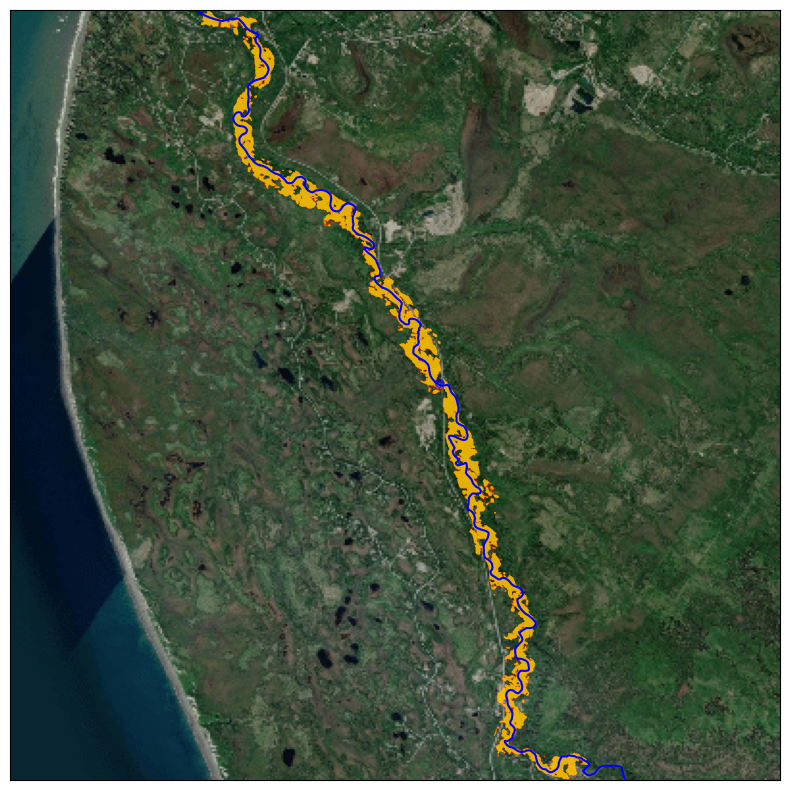

In [221]:
## Plot data layers on top of a ESRI basemap... bounding box determined by the CatFIM library extent

# Input plot parameters
plot_title = ''



# ------------------------------------------------------------------


# Get bounding rectangle of filtered CatFIM library
xmin_bounds, ymin_bounds, xmax_bounds, ymax_bounds = catfim_library_filt.total_bounds

# Get max length of CatFIM bounding rectangle
xlen = xmax_bounds-xmin_bounds
ylen = ymax_bounds-ymin_bounds
max_len = max(xlen, ylen)

# Create centroid coords
xcoord = xmin_bounds + xlen/2
ycoord = ymin_bounds + ylen/2

# Make a new bounding square, using CatFIM centroid and the max rectangle length
map_length_half = max_len/2

xleft = xcoord-map_length_half
xright = xcoord+map_length_half
ybottom = ycoord-map_length_half
ytop = ycoord+map_length_half

# Organize new bounding box coordinates
x = (xleft, xright)
y = (ybottom, ytop)


# Pull aerial imagery basemap from ESRI API
esri_url = f"https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?bbox={x[0]}%2C{y[0]}%2C{x[1]}%2C{y[1]}&bboxSR={EPSG}&layers=0&size=&imageSR=5070&transparent=true&dpi=200&f=image"
esri_aerial = Image.open(requests.get(esri_url, stream=True).raw).convert('RGBA')

# Assmeble baseplot
f, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(esri_aerial, extent=(x[0],x[1],y[0],y[1]))

# Plot filtered CatFIM library
catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.5)

# Add additional geodataframe layers
points_filt_gdf.plot(ax=ax, color='blue', alpha=0.5)
flowline_filt_gdf.plot(ax=ax, color='blue', alpha=1) 
# xsection_gdf.plot(ax=ax, color='white', alpha=0.5)

# Set bounds and labels
ax.set_xbound([x[0],x[1]])
ax.set_ybound([y[0],y[1]])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(plot_title)


plt.show()

### Generate Elevation Cross-section

In [222]:
## Generate DEM path

root_dem_path = '/data/inputs/3dep_dems/'

# huc = '06010105'
huc = '19020301'

if huc[0:2] == '19':
    dem_name = f'HUC8_{huc}_dem.tif'
    dem_path = os.path.join(root_dem_path, '10m_South_Alaska', '23_11_07', dem_name)
else:
    huc6 = huc[0:6]
    dem_name = f'HUC6_{huc6}_dem.tif'
    dem_path = os.path.join(root_dem_path, '10m_5070', dem_name)

# "/dev_fim_share/foss_fim/inputs/3dep_dems/10m_South_Alaska/23_11_07/HUC8_19020302_dem.tif"
# if 


# dem_path = '/data/inputs/3dep_dems/10m_5070/HUC6_060101_dem.tif' # TODO: make this filepath automatically generated?  

print(f'DEM path generated: {dem_path}')


DEM path generated: /data/inputs/3dep_dems/10m_South_Alaska/23_11_07/HUC8_19020301_dem.tif


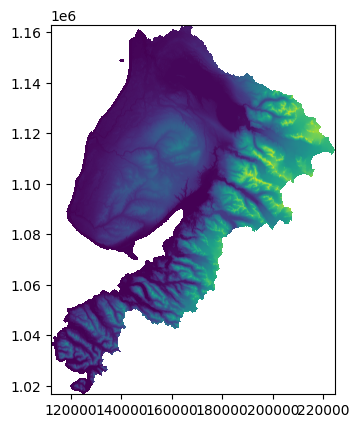

<Axes: >

In [189]:
## Optional: Open and preview the DEM

dem_raster = rasterio.open(dem_path)

show(dem_raster)

In [223]:
## Create points along cross-section line

dist_between_points = 10

xsection_line = xsection_gdf.geometry.iloc[0]

# Create points along the cross section line
xsection_points = shapely.geometry.MultiPoint()

dist_along_line = [dist_between_points/2] # this is giving the middle of the segment... is that what we want?

for i in np.arange(0, xsection_line.length, dist_between_points):
    # print(i)
    s = substring(xsection_line, i, i+dist_between_points)
    xsection_points = xsection_points.union(s.boundary)
    
    dist_along_line.append(i+dist_between_points) # TODO: should this be dist_between_points/2? to get the middle?


# Turn the multipoint object into a geodataframe
xsection_points_gdf = gpd.GeoDataFrame({'geometry': [xsection_points], 'elev': -9999},
                                       crs=xsection_gdf.crs
                                       ).explode(index_parts=True)

# Add line distance column
xsection_points_gdf['dist_along_line'] = dist_along_line

# Calculate the cross section halfway point
xsection_midpoint = dist_along_line[int(len(dist_along_line)/2)]


print(f'Generated {len(xsection_points_gdf)} cross-section points.')
# print(xsection_points_gdf)

Generated 102 cross-section points.


In [227]:
# xsection_points_gdf.crs


In [235]:
## Get the elevation for at each point from the DEM

# Read the raster file
with rasterio.open(dem_path) as src:

    # Get raster projection
    rast_proj = src.crs

    # Temporarily project cross-section points to match raster (it's easier this way)
    xsection_points_temp_proj_gdf = xsection_points_gdf.to_crs(rast_proj)

    # Extract raster values at point locations
    values = []
    for point in xsection_points_temp_proj_gdf.geometry:
        x, y = point.x, point.y
        row, col = src.index(x, y)
        value = src.read(1, window=((row, row + 1), (col, col + 1)))[0, 0]
        values.append(value)

    # Add values to the point dataframe
    xsection_points_temp_proj_gdf['elev'] = values

# Overwrite the old crosssection points gdf with the new elevation one
xsection_points_gdf = xsection_points_temp_proj_gdf.to_crs(EPSG)
    
print(xsection_points_gdf)
print('Got elevation for each cross-section point') 

            elev                          geometry  dist_along_line
0 0    44.827232  POINT (-3266826.774 5015437.485)              5.0
  1    45.284344   POINT (-3266824.13 5015427.841)             10.0
  2    45.763443  POINT (-3266821.485 5015418.197)             20.0
  3    45.908772  POINT (-3266818.841 5015408.553)             30.0
  4    46.033909  POINT (-3266816.196 5015398.909)             40.0
...          ...                               ...              ...
  97   53.075966  POINT (-3266570.255 5014502.018)            970.0
  98   52.910660   POINT (-3266567.61 5014492.374)            980.0
  99   53.184959   POINT (-3266564.966 5014482.73)            990.0
  100  53.292324  POINT (-3266562.321 5014473.086)           1000.0
  101  53.893173  POINT (-3266561.361 5014469.585)           1010.0

[102 rows x 3 columns]
Got elevation for each cross-section point


In [236]:
## Intersect the cross section points with the CatFIM library

xsection_points_overlay_gdf = gpd.overlay(xsection_points_gdf, catfim_library_filt, how='intersection')

# Filter so there's only one row per point (with smallest flood level kept)
xsection_catfim_filt = []

# Get unique distance markers
distances_list = xsection_points_overlay_gdf['dist_along_line'].unique()

# Iterate through each distance marker
for dist in distances_list:
    
    # Filter the rows given distance
    filtered_df = xsection_points_overlay_gdf[xsection_points_overlay_gdf['dist_along_line'] == dist]
    
    # Get the row with the highest plot order (color plotted on top)
    min_row = filtered_df.loc[filtered_df['plot_order'].idxmax()]
    
    # Append the result for this distance marker
    xsection_catfim_filt.append(min_row)

# Convert the results list into a DataFrame to view all results
xsection_catfim_filt_gdf = gpd.GeoDataFrame(xsection_catfim_filt)

# xsection_catfim_filt_gdf
print('Intersected and overlaid cross section points with CatFIM library.')

Intersected and overlaid cross section points with CatFIM library.


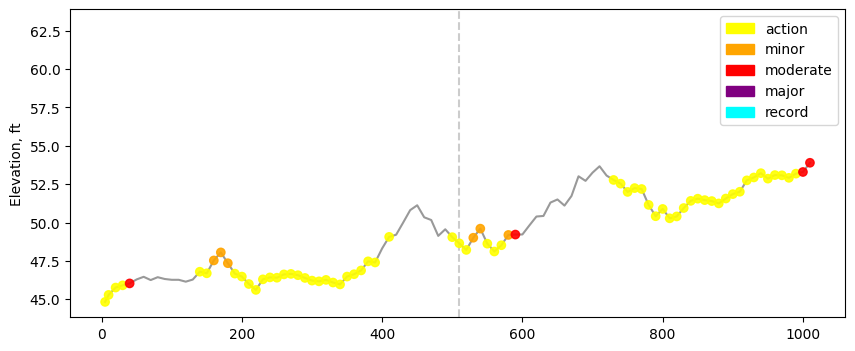

In [239]:
## Parameters ------------------------

# Number of ft above highest CatFIM library point to show
elev_upper_buffer_ft = 10

# Number of points to show on either side of CatFIM library
num_points_buffer = 5


# Whether to save the plot (True/False)
save_plot = False

# Additional label for plot file, if needed
plot_label = ''


## Plotting ------------------------ 


# Set up map
f, ax = plt.subplots(figsize=(10, 4))

# Add elevation line
plt.plot(xsection_points_gdf.dist_along_line, xsection_points_gdf.elev, color = 'gray', alpha=0.8, zorder=2) 

# Add CatFIM points
plt.scatter(x=xsection_catfim_filt_gdf.dist_along_line, y=xsection_catfim_filt_gdf.elev, color=xsection_catfim_filt_gdf.color, alpha=0.9, zorder=3)

# Add a dotted line at the approximate LID location
plt.axvline(x=xsection_midpoint, color='gray', linestyle='--', alpha=0.4)

# Calculate x axis bounds with points buffer
x_buffer = dist_between_points * num_points_buffer
x_min = xsection_catfim_filt_gdf['dist_along_line'].min() - x_buffer
x_max = xsection_catfim_filt_gdf['dist_along_line'].max() + x_buffer

# Calculate y axis bounds with an elevation buffer
y_min = xsection_catfim_filt_gdf['elev'].min() - 1
y_max = xsection_catfim_filt_gdf['elev'].max() + elev_upper_buffer_ft

# Create legend from the color dictionary
stages = list(colordict.keys())
patches = []
for stage in stages: 
    patch = mpatches.Patch(color = colordict[stage], label = stage)
    patches.append(patch)

ax.legend(handles=patches)

# Set labels and axis bounds
ax.set_xlabel('')
ax.set_ylabel('Elevation, ft')
ax.set_xbound([x_min,x_max])
ax.set_ybound([y_min,y_max])

# Save and display plot
if save_plot == True:
    # Create plot filename
    plot_name = 'catfim_crosssection_' + lid + plot_label + '.png'
    plt.savefig(plot_name)
    print(f'Saved plot as {plot_name}')

else: 
    plt.show()

### Misc Sample Code

In [266]:
# ## Plot the cross section WITH the catfim library

# plot_title = ''

# # ------------------------------------------------------------------

# # Plot gdf2 first to set the extent
# ax = xsection_gdf.plot(figsize=(6, 6), color='lightgray')

# # Plot the geodataframes
# points_filt_gdf.plot(ax=ax, color='blue', alpha=0.5)  # Adjust color and alpha as needed
# catfim_library_filt.plot(ax=ax, color=catfim_library_filt.color, alpha=0.5)  # Adjust color and alpha as needed

# flowline_filt_gdf.plot(ax=ax, color='green', alpha=0.5)  # Adjust color and alpha as needed


# # Set the plot extent to the bounds of the line segment
# minx, miny, maxx, maxy = xsection_gdf.total_bounds
# modifier = 1000 # how much to widen the extent by
# ax.set_xlim(minx-modifier, maxx+modifier)
# ax.set_ylim(miny-modifier, maxy+modifier)

# ax.set_title(plot_title)

# plt.show()

In [ ]:
# # ------ Carson's example code ------


# # Define x/y bounds
# x = (-86600, -83300)
# y = (757400, 760700)

# esri_url = f"https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?bbox={x[0]}%2C{y[0]}%2C{x[1]}%2C{y[1]}&bboxSR=5070&layers=0&size=&imageSR=5070&transparent=true&dpi=200&f=image"

# esri_aerial = Image.open(requests.get(esri_url, stream=True).raw).convert('RGBA')

# fig = plt.figure()
# ax = fig.subplots(1,2)

# im = ax[0].imshow(esri_aerial, extent=(x[0],x[1],y[0],y[1]))
# im = ax[1].imshow(esri_aerial, extent=(x[0],x[1],y[0],y[1]))

# im = ax[0].imshow(
#     fim_prod,
#     cmap='bwr',
#     extent=rem_extent,
#     interpolation='none',
#     alpha=0.6
# )
# im = ax[1].imshow(
#     fim,
#     cmap='bwr',
#     extent=rem_extent,
#     interpolation='none',
#     alpha=0.6
# )

# #plt.colorbar(im, ax=ax, location='left')
# # -87691,756758 : -79576,761088
# ax[0].set_xbound([x[0],x[1]])
# ax[0].set_ybound([y[0],y[1]])
# ax[0].set_xticks([])
# ax[0].set_yticks([])
# ax[1].set_xbound([x[0],x[1]])
# ax[1].set_ybound([y[0],y[1]])
# ax[1].set_xticks([])
# ax[1].set_yticks([])
# #ax.set_title("REM")
# fig.tight_layout()
# plt.show()